# Import libraries

In [47]:
import numpy as np
import pandas as pd
import os
import torch
import re
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from PIL import Image
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/akanshagautam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/akanshagautam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akanshagautam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/akanshagautam/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/akanshagautam/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Load images metadata to a df

In [2]:
image_dir = "/Users/akanshagautam/Documents/MTech/Thesis/Dataset/ConClip/ccneg_images/cc3m_subset_images_extracted_final"

image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

image_data = []
for root, _, files in os.walk(image_dir):
    for file in files:
        if os.path.splitext(file)[1].lower() in image_extensions:
            image_path = os.path.join(root, file)
            image_data.append({'image_name': file, 'image_path': image_path})

images_metadata_df = pd.DataFrame(image_data)
print(images_metadata_df.shape)
images_metadata_df.head()

(302123, 2)


,image_name,image_path
0,000318123.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...
1,000275481.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...
2,000204278.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...
3,000139141.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...
4,000136272.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...


# Load captions to a df

In [3]:
ccneg_preprocessed_data = torch.load("/Users/akanshagautam/Documents/MTech/Thesis/Dataset/ConClip/ccneg_preprocessed.pt")

print(f"Keys: {list(ccneg_preprocessed_data.keys())}")

Keys: ['kept', 'dropped', 'image_paths', 'annotations', 'num_ops']


In [4]:
ccneg_preprocessed_data['annotations'][0]

{'tar_path': '/workspace/datasets/cc3m/cc3m_subset/00000.tar',
 'image_number': '000000003',
 'file_extension': 'jpg',
 'json': {'caption': 'actor attends the season premiere',
  'url': 'https://media.gettyimages.com/photos/aidan-gillen-attends-the-season-7-premiere-of-hbos-game-of-thrones-at-picture-id817717986?s=612x612',
  'key': '000000003',
  'status': 'success',
  'error_message': None,
  'width': 224,
  'height': 224,
  'original_width': 488,
  'original_height': 612,
  'exif': '{"Image ImageDescription": "LOS ANGELES, CA - JULY 12:  Aidan Gillen attends the Season 7 Premiere Of HBO\'s \\"Game Of Thrones\\" at Walt Disney Concert Hall on July 12, 2017 in Los Angeles, California.  (Photo by C Flanigan/Getty Images)", "Image Copyright": "2017 C Flanigan"}',
  'sha256': 'eef633b4a3b42ec7c4dc6d332575f562a969683273dbada9617fd2d7bef3fd72'},
 'caption': 'actor attends the season premiere',
 'labels': 'musician,premiere,event,singer,suit,performance',
 'MIDs': '/m/09jwl,/m/03n3f3,/m/081

In [5]:
annotations = ccneg_preprocessed_data['annotations']

rows = []

for i in range(len(annotations)):
    ann = annotations[i]

    row = {
        'image_number': ann.get('image_number'),
        'file_extension':  ann.get('file_extension'),
        'true_caption': ann.get('caption'),
        'labels': ann.get('labels'),
        'negated_caption': ann.get('sop_data', {}).get('negative-prompt'),
        'url': ann.get('json', {}).get('url'),
        'subject': ann.get('sop_data', {}).get('sop_decomposition', {}).get('subject'),
        'object_predicate_pairs': ann.get('sop_data', {}).get('sop_decomposition', {}).get('object-predicate-pairs', {}),
        'predicate': ann.get('sop_data', {}).get('sop_decomposition', {}).get('predicate'),
        'negate_word_present': ann.get('negate_word_present'),
        'num_ops': ann.get('num_ops')
    }

    rows.append(row)

annotiation_df = pd.DataFrame(rows)
print(annotiation_df.shape)
annotiation_df.head(1)


(228246, 11)


,image_number,file_extension,true_caption,labels,negated_caption,url,subject,object_predicate_pairs,predicate,negate_word_present,num_ops
0,000000003,jpg,actor attends the season premiere,"musician,premiere,event,singer,suit,performance","actor, not attending the season premiere",https://media.gettyimages.com/photos/aidan-gil...,actor,"[{'object': 'season premiere', 'predicate': 'a...",None,True,1


In [22]:
annotiation_df['image_name'] = annotiation_df['image_number'] + '.' + annotiation_df['file_extension']

merged_df = pd.merge(annotiation_df, images_metadata_df, on='image_name', how='inner')
print(merged_df.shape)
merged_df.head()

(228246, 13)


,image_number,file_extension,true_caption,labels,negated_caption,url,subject,object_predicate_pairs,predicate,negate_word_present,num_ops,image_name,image_path
0,000000003,jpg,actor attends the season premiere,"musician,premiere,event,singer,suit,performance","actor, not attending the season premiere",https://media.gettyimages.com/photos/aidan-gil...,actor,"[{'object': 'season premiere', 'predicate': 'a...",None,True,1,000000003.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...
1,000000005,jpg,a woman walks her dog on the beach .,"water,beach,sea,shore,ocean,canidae,dog,sky,wa...",a woman walks on the beach without her dog,https://media.gettyimages.com/photos/woman-wal...,woman,"[{'object': 'dog', 'predicate': 'walks her on ...",None,True,1,000000005.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...
2,000000009,jpg,close up portrait of a smiling middle aged wom...,"hair,sitting,facial expression,nose,arm,cheek,...",close up portrait of a smiling middle aged wom...,http://l7.alamy.com/zooms/29164f933d7340be90af...,portrait,"[{'object': 'woman', 'predicate': 'of a'}, {'o...",None,True,4,000000009.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...
3,000000018,jpg,man sitting on floor beside a pool using laptop,"sitting,tablet computer,table,technology,grass...",man sitting on floor without a pool using laptop,https://media.gettyimages.com/photos/man-sitti...,man,"[{'object': 'floor', 'predicate': 'on'}, {'obj...",None,True,3,000000018.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...
4,000000007,jpg,a beautiful day with some buildings and plants .,"residential area,property,home,building,house,...",a beautiful day without plants,https://d1tq208oegmb9e.cloudfront.net/site_pho...,day,"[{'object': 'buildings', 'predicate': 'with so...",None,True,2,000000007.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...


In [23]:
def clean_caption(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
        text = text.strip()
        return text
    return text

merged_df['true_caption_clean'] = merged_df['true_caption'].apply(clean_caption)
merged_df['negated_caption_clean'] = merged_df['negated_caption'].apply(clean_caption)

merged_df.head()

,image_number,file_extension,true_caption,labels,negated_caption,url,subject,object_predicate_pairs,predicate,negate_word_present,num_ops,image_name,image_path,true_caption_clean,negated_caption_clean
0,000000003,jpg,actor attends the season premiere,"musician,premiere,event,singer,suit,performance","actor, not attending the season premiere",https://media.gettyimages.com/photos/aidan-gil...,actor,"[{'object': 'season premiere', 'predicate': 'a...",None,True,1,000000003.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,actor attends the season premiere,actor not attending the season premiere
1,000000005,jpg,a woman walks her dog on the beach .,"water,beach,sea,shore,ocean,canidae,dog,sky,wa...",a woman walks on the beach without her dog,https://media.gettyimages.com/photos/woman-wal...,woman,"[{'object': 'dog', 'predicate': 'walks her on ...",None,True,1,000000005.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,a woman walks her dog on the beach,a woman walks on the beach without her dog
2,000000009,jpg,close up portrait of a smiling middle aged wom...,"hair,sitting,facial expression,nose,arm,cheek,...",close up portrait of a smiling middle aged wom...,http://l7.alamy.com/zooms/29164f933d7340be90af...,portrait,"[{'object': 'woman', 'predicate': 'of a'}, {'o...",None,True,4,000000009.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,close up portrait of a smiling middle aged wom...,close up portrait of a smiling middle aged wom...
3,000000018,jpg,man sitting on floor beside a pool using laptop,"sitting,tablet computer,table,technology,grass...",man sitting on floor without a pool using laptop,https://media.gettyimages.com/photos/man-sitti...,man,"[{'object': 'floor', 'predicate': 'on'}, {'obj...",None,True,3,000000018.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,man sitting on floor beside a pool using laptop,man sitting on floor without a pool using laptop
4,000000007,jpg,a beautiful day with some buildings and plants .,"residential area,property,home,building,house,...",a beautiful day without plants,https://d1tq208oegmb9e.cloudfront.net/site_pho...,day,"[{'object': 'buildings', 'predicate': 'with so...",None,True,2,000000007.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,a beautiful day with some buildings and plants,a beautiful day without plants


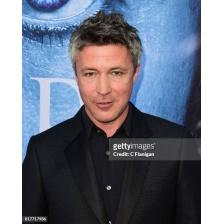

true caption:  actor attends the season premiere
negated caption:  actor, not attending the season premiere


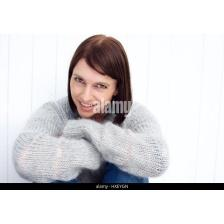

true caption:  close up portrait of a smiling middle aged woman sitting against white wall
negated caption:  close up portrait of a smiling middle aged woman without white wall


In [51]:
def load_image(image_path):
    img = Image.open(image_path)
    display(img)
    return img

load_image(merged_df.iloc[0]['image_path'])
print("true caption: ", merged_df.iloc[0]['true_caption'])
print("negated caption: ", merged_df.iloc[0]['negated_caption'])

load_image(merged_df.iloc[2]['image_path'])
print("true caption: ", merged_df.iloc[2]['true_caption'])
print("negated caption: ", merged_df.iloc[2]['negated_caption'])

In [44]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_sentence(sentence):
    if isinstance(sentence, str):
        words = sentence.split(" ")
        pos_tags = nltk.pos_tag(words)
        lemmatized_words = [
            lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags
        ]
        return ' '.join(lemmatized_words)
    return sentence

def extract_unique_lemmatized_words(row):
    true_words = set(row['true_caption_lemmatized'].split())
    negated_words = set(row['negated_caption_lemmatized'].split())
    unique_words = negated_words - true_words
    return list(unique_words)

merged_df['true_caption_lemmatized'] = merged_df['true_caption_clean'].apply(lemmatize_sentence)
merged_df['negated_caption_lemmatized'] = merged_df['negated_caption_clean'].apply(lemmatize_sentence)
merged_df['unique_negated_words_lemmatized'] = merged_df.apply(extract_unique_lemmatized_words, axis=1)

merged_df.head()

,image_number,file_extension,true_caption,labels,negated_caption,url,subject,object_predicate_pairs,predicate,negate_word_present,num_ops,image_name,image_path,true_caption_clean,negated_caption_clean,true_caption_lemmatized,negated_caption_lemmatized,unique_negated_words_lemmatized
0,000000003,jpg,actor attends the season premiere,"musician,premiere,event,singer,suit,performance","actor, not attending the season premiere",https://media.gettyimages.com/photos/aidan-gil...,actor,"[{'object': 'season premiere', 'predicate': 'a...",None,True,1,000000003.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,actor attends the season premiere,actor not attending the season premiere,actor attend the season premiere,actor not attend the season premiere,[not]
1,000000005,jpg,a woman walks her dog on the beach .,"water,beach,sea,shore,ocean,canidae,dog,sky,wa...",a woman walks on the beach without her dog,https://media.gettyimages.com/photos/woman-wal...,woman,"[{'object': 'dog', 'predicate': 'walks her on ...",None,True,1,000000005.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,a woman walks her dog on the beach,a woman walks on the beach without her dog,a woman walk her dog on the beach,a woman walk on the beach without her dog,[without]
2,000000009,jpg,close up portrait of a smiling middle aged wom...,"hair,sitting,facial expression,nose,arm,cheek,...",close up portrait of a smiling middle aged wom...,http://l7.alamy.com/zooms/29164f933d7340be90af...,portrait,"[{'object': 'woman', 'predicate': 'of a'}, {'o...",None,True,4,000000009.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,close up portrait of a smiling middle aged wom...,close up portrait of a smiling middle aged wom...,close up portrait of a smile middle age woman ...,close up portrait of a smile middle age woman ...,[without]
3,000000018,jpg,man sitting on floor beside a pool using laptop,"sitting,tablet computer,table,technology,grass...",man sitting on floor without a pool using laptop,https://media.gettyimages.com/photos/man-sitti...,man,"[{'object': 'floor', 'predicate': 'on'}, {'obj...",None,True,3,000000018.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,man sitting on floor beside a pool using laptop,man sitting on floor without a pool using laptop,man sit on floor beside a pool use laptop,man sit on floor without a pool use laptop,[without]
4,000000007,jpg,a beautiful day with some buildings and plants .,"residential area,property,home,building,house,...",a beautiful day without plants,https://d1tq208oegmb9e.cloudfront.net/site_pho...,day,"[{'object': 'buildings', 'predicate': 'with so...",None,True,2,000000007.jpg,/Users/akanshagautam/Documents/MTech/Thesis/Da...,a beautiful day with some buildings and plants,a beautiful day without plants,a beautiful day with some building and plant,a beautiful day without plant,[without]


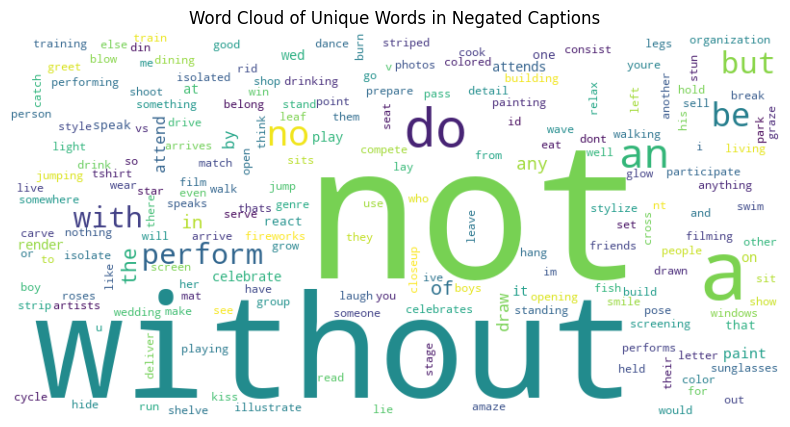

In [52]:
all_unique_words = [word for sublist in merged_df['unique_negated_words_lemmatized'] for word in sublist]
word_freq = Counter(all_unique_words)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Unique Words in Negated Captions")
plt.show()

# Load distractor images

In [58]:
distractor_image_mapping = torch.load("/Users/akanshagautam/Documents/MTech/Thesis/Dataset/ConClip/distractor_image_mapping.pt")

print("Distractor Image Mapping shape:", len(distractor_image_mapping))

Distractor Image Mapping shape: 296805


In [59]:
distractor_image_mapping[0]

[77975, 95218, 32838]